In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

load in dataset

In [2]:
df = pd.read_csv('C:/Users/Lenovo/Desktop/Yu Lab/titanic - binary outcome/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


select variables that are important

In [3]:
df = df.iloc[:,[1,2,4,5,6,7,9,11]]
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


check variable description

In [4]:
df.describe(), df[['Survived','Pclass','Sex','Embarked']].describe()

(         Survived      Pclass         Age       SibSp       Parch        Fare
 count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
 mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
 std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
 min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
 25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
 50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
 75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
 max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200,
          Survived      Pclass
 count  891.000000  891.000000
 mean     0.383838    2.308642
 std      0.486592    0.836071
 min      0.000000    1.000000
 25%      0.000000    2.000000
 50%      0.000000    3.000000
 75%      1.000000    3.000000
 max      1.000000    3.000000)

check variable correlation

(          Survived    Pclass       Age     SibSp     Parch      Fare
 Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
 Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
 Age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067
 SibSp    -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651
 Parch     0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225
 Fare      0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000,
 <matplotlib.axes._subplots.AxesSubplot at 0x1edeeb80f08>)

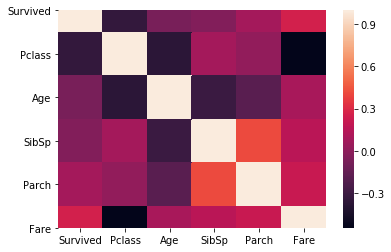

In [5]:
# correlation
cor = df.corr()
cor, sns.heatmap(cor)

check missing data, fill in missing data and check again

In [6]:
# check missing value
pd.isnull(df).sum() > 0

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [7]:
# fill in missing value and check again ## see how the missing percentage will affect the model outcome
df["Age"] = df.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))
df['Embarked'] = df.groupby('Pclass')['Embarked'].apply(lambda x:x.fillna(x.value_counts().index.tolist()[0]))
pd.isnull(df).sum() > 0

Survived    False
Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

create dummy variables for categorical variables

In [8]:
# encoding: create dummy variable
enc = OneHotEncoder(handle_unknown='ignore')
edf = pd.DataFrame(enc.fit_transform(df[['Pclass','Sex','Embarked']]).toarray())
edf.columns = enc.get_feature_names(['Pclass','Sex','Embarked'])
edf.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [9]:
df.drop(['Pclass','Sex','Embarked'] ,axis=1, inplace=True)
df= pd.concat([df, edf ], axis=1)
df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


split train and test dataset

In [10]:
# split x and y
y = df.Survived
x = df.drop(['Survived'], axis = 1)
xtrain, xtest, ytrain,ytest = train_test_split(x,y,test_size = 0.3, stratify = y)

normalize numerical variables

In [11]:
# normalize age # try without normalization see how outcome changes
scaler = StandardScaler()
xtrain.iloc[:,[0,3]] = scaler.fit_transform(xtrain.iloc[:,[0,3]])
xtest.iloc[:,[0,3]] = scaler.transform(xtest.iloc[:,[0,3]])

C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


build random forest model

In [12]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'gini', random_state = 42)
classifier.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

test model performance on test data

In [13]:
ypred = classifier.predict(xtest)
confusion_matrix(ytest, ypred)

array([[146,  19],
       [ 27,  76]], dtype=int64)

In [14]:
xtest

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
754,1.373494,1,2,0.711013,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
659,2.106788,0,2,1.744794,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
823,-0.166424,0,1,-0.413780,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
168,0.566870,0,0,-0.125756,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
17,-0.019765,0,0,-0.402537,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
715,-0.753059,0,0,-0.517104,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
618,-1.853000,2,1,0.154238,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
220,-0.973047,0,0,-0.508539,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
845,0.933517,0,0,-0.519246,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [15]:
classifier.score(xtest,ytest) # accuracy

0.8283582089552238

In [16]:
report = pd.DataFrame(classification_report(ytest, ypred,output_dict=True))
report

,0,1,accuracy,macro avg,weighted avg
precision,0.843931,0.800000,0.828358,0.821965,0.827047
recall,0.884848,0.737864,0.828358,0.811356,0.828358
f1-score,0.863905,0.767677,0.828358,0.815791,0.826922
support,165.000000,103.000000,0.828358,268.000000,268.000000


In [17]:
# check predited outcome and probability
predictions = classifier.predict_proba(xtest)
xtest["actual_outcome"] = ytest
xtest["prediction"] = ypred.tolist()
xtest["prob_died"] = predictions[:,0].tolist()
xtest["prob_surv"] = predictions[:,1].tolist()

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

In [19]:
# save prediction to loacl computer
xtest.to_csv("C:/Users/Lenovo/Desktop/Yu Lab/titanic - binary outcome/prediction.csv")

In [18]:
xtest

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,actual_outcome,prediction,prob_died,prob_surv
241,24.0,1,0,15.5000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1,1,0.0,1.0
27,19.0,3,2,263.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.5,0.5
836,21.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.0,0.0
780,13.0,0,0,7.2292,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,0,0.7,0.3
455,29.0,0,0,7.8958,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,33.0,0,0,5.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.7,0.3
876,20.0,0,0,9.8458,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.0,0.0
678,43.0,1,6,46.9000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0,1.0,0.0
456,65.0,0,0,26.5500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.9,0.1


In [19]:
xtest[xtest.actual_outcome!=xtest.prediction]

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,actual_outcome,prediction,prob_died,prob_surv
780,13.0,0,0,7.2292,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,0,0.700000,0.300000
455,29.0,0,0,7.8958,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0,1.000000,0.000000
828,24.0,0,0,7.7500,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,0,1.000000,0.000000
132,47.0,1,0,14.5000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,1,0.400000,0.600000
475,37.0,0,0,52.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0.300000,0.700000
35,42.0,1,0,52.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0.200000,0.800000
510,29.0,0,0,7.7500,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1,0,1.000000,0.000000
498,25.0,1,2,151.5500,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.300000,0.700000
821,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0,1.000000,0.000000
852,9.0,1,1,15.2458,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0,1,0.400000,0.600000


check feature importance

In [20]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                   index = df.columns[1:],
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances # gini impurity

,importance
Fare,0.244438
Age,0.235940
Sex_male,0.186631
Sex_female,0.117627
Pclass_3,0.047882
Parch,0.044302
Pclass_1,0.041012
SibSp,0.034999
Pclass_2,0.015933
Embarked_S,0.013179


cross validation

In [27]:
# get training adn testing data again
# split x and y
y = df.Survived
x = df.drop(['Survived'], axis = 1)
xtrain, xtest, ytrain,ytest = train_test_split(x,y,test_size = 0.3, stratify = y)
# normalize age
#scaler = StandardScaler()
#xtrain.iloc[:,[0,3]] = scaler.fit_transform(xtrain.iloc[:,[0,3]])
#xtest.iloc[:,[0,3]] = scaler.transform(xtest.iloc[:,[0,3]])

In [28]:
param_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [3, 4, 5, 6, 7],
 'min_samples_split': [2, 4, 6, 8, 10],
 'n_estimators': [100,110, 120,130, 140, 150,160, 170, 180,190, 200]}

In [29]:
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
search = rf_random.fit(xtrain,ytrain)
best = search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished
C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [30]:
# bets score and best parameters
search.best_score_, best

(0.8362760834670947,
 {'n_estimators': 100,
  'min_samples_split': 8,
  'min_samples_leaf': 4,
  'max_features': 'sqrt',
  'max_depth': 100,
  'bootstrap': False})

refit model with best hyperparameters and check model performance again

In [31]:
search.best_score_, best# apply best parameters and get model scores
best_model = RandomForestClassifier(n_estimators= 100,
  min_samples_split= 8,
  min_samples_leaf= 4,
  max_features='sqrt',
  max_depth= 100,
  bootstrap=False)
best_model.fit(xtrain, ytrain)
ypred = best_model.predict(xtest)
pd.DataFrame(classification_report(ytest, ypred,output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.824561,0.752577,0.798507,0.788569,0.796896
recall,0.854545,0.708738,0.798507,0.781642,0.798507
f1-score,0.839286,0.730000,0.798507,0.784643,0.797284
support,165.000000,103.000000,0.798507,268.000000,268.000000


In [32]:
classifier.score(xtest,ytest) # accuracy

0.8917910447761194

In [33]:
#check prediction outcome
# check predited outcome and probability
predictions = classifier.predict_proba(xtest)
xtest["actual_outcome"] = ytest
xtest["prediction"] = ypred.tolist()
xtest["prob_died"] = predictions[:,0].tolist()
xtest["prob_surv"] = predictions[:,1].tolist()
xtest

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,actual_outcome,prediction,prob_died,prob_surv
311,18.0,2,2,262.3750,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1,0.100000,0.900000
293,24.0,0,0,8.8500,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,1,0.800000,0.200000
692,24.0,0,0,56.4958,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0,0.416667,0.583333
482,50.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0.900000,0.100000
698,49.0,1,1,110.8833,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0,0.700000,0.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,34.0,1,0,21.0000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,1.000000,0.000000
528,39.0,0,0,7.9250,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0.520000,0.480000
349,42.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,1.000000,0.000000
402,21.0,1,0,9.8250,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0,0.900000,0.100000


In [ ]:
xtest.to_csv()

Predict new data

In [65]:
# load in new dataset
test = pd.read_csv('C:/Users/Lenovo/Desktop/Yu Lab/titanic - binary outcome/test.csv')
test = test.iloc[:,[1,3,4,5,6,8,10]]
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [66]:
# check missing value
pd.isnull(test).sum() > 0

Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare         True
Embarked    False
dtype: bool

In [67]:
# fill in missing data and check again
test["Age"] = test.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))
test["Fare"] = test.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))
pd.isnull(test).sum() > 0

Pclass      False
Sex         False
Age         False
SibSp       False
Parch       False
Fare        False
Embarked    False
dtype: bool

In [68]:
# encoding: create dummy variable
tenc = OneHotEncoder(handle_unknown='ignore')
tedf = pd.DataFrame(tenc.fit_transform(test[['Pclass','Sex','Embarked']]).toarray())
tedf.columns = tenc.get_feature_names(['Pclass','Sex','Embarked'])
tedf.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [69]:
# replace original variable with the new dummy variables
test.drop(['Pclass','Sex','Embarked'] ,axis=1, inplace=True)
test= pd.concat([test, tedf ], axis=1)
test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,34.5,0,0,7.8292,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [70]:
# normalize age and fare variable
scaler = StandardScaler()
test.iloc[:,[0,3]] = scaler.fit_transform(test.iloc[:,[0,3]])
test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.393048,0,0,-0.497071,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.356309,1,0,-0.511934,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,2.512223,0,0,-0.463762,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.184909,0,0,-0.482135,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.570214,1,1,-0.417159,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [75]:
test

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.393048,0,0,-0.497071,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.356309,1,0,-0.511934,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,2.512223,0,0,-0.463762,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.184909,0,0,-0.482135,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.570214,1,1,-0.417159,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.416092,0,0,-0.493113,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
414,0.739822,0,0,1.314555,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
415,0.701291,0,0,-0.507453,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
416,-0.416092,0,0,-0.493113,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [79]:
# make and show prediction
ytpred = best_model.predict(test)
tpredictions = best_model.predict_proba(test)
test["prediction"] = ytpred # no actual outcome in this dataset
test["prob_died"] = tpredictions[:,0].tolist()
test["prob_surv"] = tpredictions[:,1].tolist()
test

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,prediction,prob_died,prob_surv
0,0.393048,0,0,-0.497071,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0.937385,0.062615
1,1.356309,1,0,-0.511934,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0.575602,0.424398
2,2.512223,0,0,-0.463762,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,0.880447,0.119553
3,-0.184909,0,0,-0.482135,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.738819,0.261181
4,-0.570214,1,1,-0.417159,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,0.511769,0.488231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,-0.416092,0,0,-0.493113,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.956482,0.043518
414,0.739822,0,0,1.314555,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0.012533,0.987467
415,0.701291,0,0,-0.507453,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.951724,0.048276
416,-0.416092,0,0,-0.493113,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0.956482,0.043518


predict one observation at a time

In [80]:
newdf = {"Age":[(30-x.Age.mean())/x.Age.std()], "SibSp":[1],"Parch":[0],"Fare":[(70-x.Fare.mean())/x.Fare.std()],
      "Pclass_1":[0],"Pclass_2":[1],"Pclass_3":[0],
      "Sex_female":[0],"Sex_male":[1],"Embarked_C":[0],"Embarked_Q":[0],"Embarked_S":[1]}
newdf = pd.DataFrame(newdf)
ynewpred = best_model.predict(newdf)
predprob = best_model.predict_proba(newdf)
ynewpred,predprob

(array([0], dtype=int64), array([[0.82765245, 0.17234755]]))